In [1]:
!nvidia-smi

Sun Mar 21 12:36:02 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.64       Driver Version: 440.64       CUDA Version: 10.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  TITAN RTX           Off  | 00000000:03:00.0 Off |                  N/A |
| 41%   61C    P2    69W / 280W |  14532MiB / 24219MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  TITAN RTX           Off  | 00000000:04:00.0 Off |                  N/A |
| 41%   49C    P2    60W / 280W |   5663MiB / 24220MiB |     16%      Default |
+-------------------------------+----------------------+----------------------+
|   2  T

In [2]:
import numpy as np
import torch
import torchvision

import matplotlib.pyplot as plt
from scipy.special import softmax

import foolbox as fb
from torchvision import transforms
from boundary_attack import BoundaryAttack

In [3]:
device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')

In [4]:
model = torch.load('CIFAR10_ResNet50.pth', map_location=device)

In [5]:
test_tf = transforms.Compose([
    transforms.ToTensor()
])

test = torchvision.datasets.CIFAR10('./', download=True, train=False, transform=test_tf)

testloader = torch.utils.data.DataLoader(dataset=test, batch_size=256, shuffle=False)

Files already downloaded and verified


In [6]:
examples = enumerate(test)
batch_idx, (example_data, example_targets) = next(examples)

In [7]:
init = 1
start = 4

input_or_adv = test[init][0]
example_targets = test[init][1]
starting_points = test[start][0]

In [8]:
input_or_adv = input_or_adv.reshape(1, 3, 32, 32)
starting_points = starting_points.reshape(1, 3, 32, 32)

In [9]:
input_or_adv = input_or_adv.to(device)
starting_points = starting_points.to(device)
label = torch.tensor([example_targets]).to(device)

In [10]:
fmodel = fb.PyTorchModel(model, bounds=(0, 1), device=device)
attack = BoundaryAttack(steps=10000, tensorboard='./logs')

In [11]:
%%time

adversarial = attack(model=fmodel, 
                     inputs=input_or_adv, 
                     starting_points=starting_points, 
                     criterion=fb.criteria.Misclassification(label), 
                     epsilons=1e-3)

100%|██████████| 10000/10000 [04:22<00:00, 38.10it/s]

CPU times: user 4min 34s, sys: 19.2 s, total: 4min 53s
Wall time: 4min 22s


In [12]:
adv = adversarial[0].cpu().numpy()
input_or_adv = input_or_adv.to('cpu')
starting_points = starting_points.to('cpu')

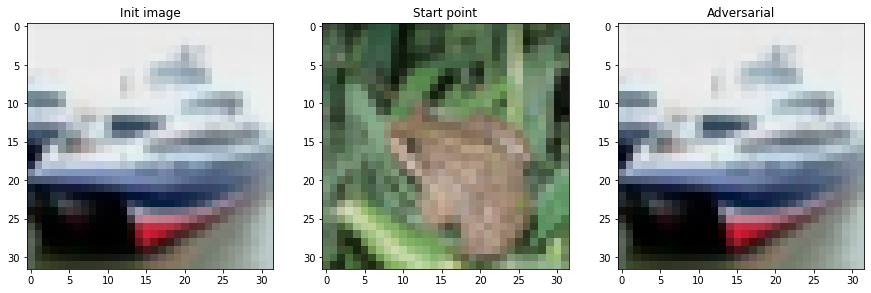

In [13]:
fig, ax = plt.subplots(figsize=[15, 25])

plt.subplot(131)
plt.imshow(np.array(input_or_adv[0]).transpose((1,2,0)))
plt.title('Init image')

plt.subplot(132)
plt.imshow(np.array(starting_points[0]).transpose((1,2,0)))
plt.title('Start point')

plt.subplot(133)
plt.imshow(np.array(adv[0]).transpose((1,2,0)))
plt.title('Adversarial')

plt.savefig('example.pdf')

plt.show()

In [14]:
before = model.forward(input_or_adv.to(device)).cpu().detach().numpy()
label_before = np.argmax(before)
before_prob = softmax(before)[0][label_before]
print('label before:', label_before, '  prob before:', before_prob)

after = model.forward(adversarial[0]).cpu().detach().numpy()
label_after = np.argmax(after)
prob_after = softmax(after)[0][label_after]
prob_after_init = softmax(after)[0][label_before]
print('label after:', label_after, '   prob after:', prob_after, '   prob init:', prob_after_init)

label before: 8   prob before: 0.6173749
label after: 1    prob after: 0.4980647    prob init: 0.49804428


In [15]:
distance = np.linalg.norm(input_or_adv.cpu().detach().numpy() - adversarial[0].cpu().detach().numpy())

In [16]:
distance / (3*32*32)

6.112223976136495e-06